# Onset Time Calculation
Going to investigate the automation of start and end times of the onset phase. For simplicity we will use the manual background timings from Hugh's paper and incorporate our automatic ones afterwards in order to see the difference in results.

We will start with the 2011-08-09 X-class flare as it has one of the clearset onset phases.

In [52]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import re

from scipy.io import readsav
from scipy import stats
from scipy import signal

from datetime import datetime

from astropy.time import Time
from astropy.time import TimeDelta

from sunpy import timeseries as ts
from sunpy.net import attrs as a
from sunpy.net import Fido
from sunpy.time import parse_time, find_time

import pandas as pd

import goesxrs_temp as gtem #from Ian's functions

from Onsets_temp import *

# Just setup plot fonts
plt.rcParams.update({'font.size': 18,'font.family':"sans-serif",\
                         'font.sans-serif':"Arial",'mathtext.default':"regular", 'axes.linewidth' : 2})

In [53]:
data = r"C:\Users\William\Documents\University\MastersProj\Data\Test\GOES15_2s\sci_gxrs-l2-irrad_g15_d20101105_v0-0-0.nc"
g15 = ts.TimeSeries(data, concatenate=True)
trange = a.Time("2010-11-05 12:30:00", "2010-11-05 14:00:00")
trunc_g15=g15.truncate(trange.start.iso,trange.end.iso)
g_tims = trunc_g15.index
g_short = trunc_g15.quantity("xrsa").value
g_long = trunc_g15.quantity("xrsb").value

## Having a look at the variance plot to determine background

c:\Users\William\Documents\University\MastersProj\hot_onset\lib\site-packages\numpy\core\fromnumeric.py:3715: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\William\Documents\University\MastersProj\hot_onset\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\William\Documents\University\MastersProj\hot_onset\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


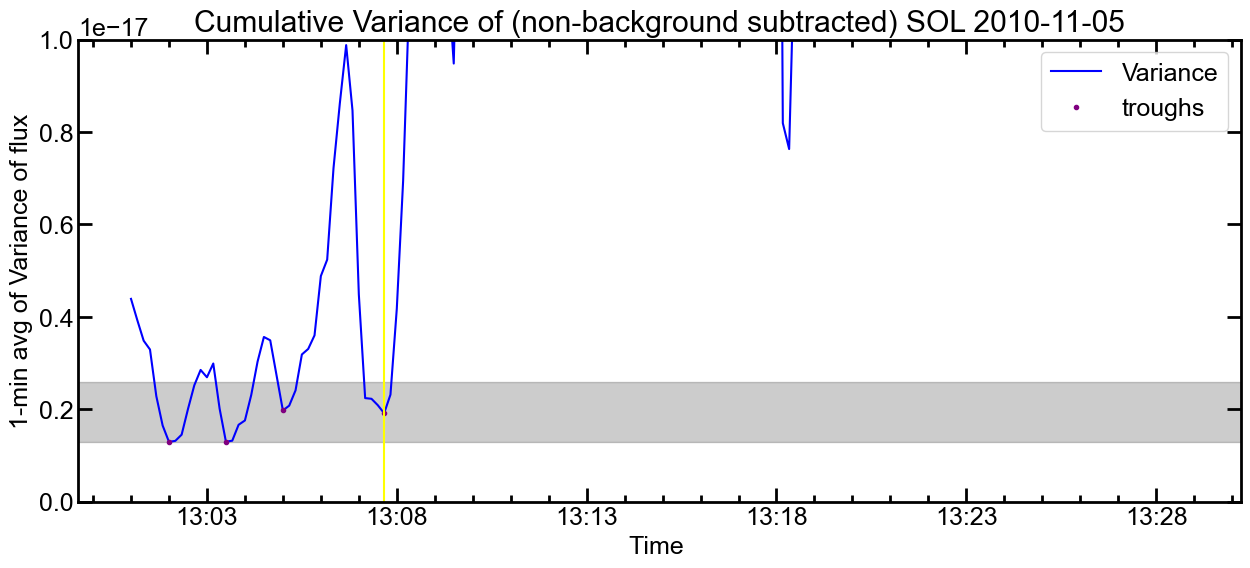

In [54]:
trange_search = a.Time("2010-11-05 13:00:00", "2010-11-05 13:29:00")
trunc_search = g15.truncate(trange_search.start.iso,trange_search.end.iso)
g_tims_bcksr = trunc_search.index
g_short_bcksr = trunc_search.quantity("xrsa").value

vars_0 = []
for i in range(0,len(g_short_bcksr)):
    var = np.var(g_short_bcksr[i-30:i])
    vars_0.append(var)

smooth = pd.Series(vars_0, index = pd.DatetimeIndex(g_tims_bcksr))
smooth = smooth.resample('10S').mean()
df = pd.DataFrame({'Time': smooth.index, 'Variance': smooth.values})
df = df.dropna()

# Finding Troughs
trs, _ = signal.find_peaks(np.negative(df['Variance']), plateau_size = 1)

tr_time = []
tr_var = []
for t in trs:
    if df.iloc[t]['Variance'] >= min(df['Variance'].values) and df.iloc[t]['Variance'] <= min(df['Variance'].values)*2:
        tr_time.append(df.iloc[t]['Time'])
        tr_var.append(df.iloc[t]['Variance'])
    else:
        continue
    

fig,ax = plt.subplots(figsize=(15, 6))
plt.title('Cumulative Variance of (non-background subtracted) SOL 2010-11-05')
#plt.plot(g_tims_bcksr, vars_0, color = 'blue', label = 'Variance')
plt.plot(smooth, color = 'blue', label = 'Variance')
plt.plot(tr_time, tr_var,'.', color = 'purple', label ='troughs')
# plt.plot(g_tims_bcksr, g_short_bcksr, color = 'purple', label = 'flux')
# ax.axvline(datetime.strptime("11/05/10 13:29:00", '%m/%d/%y %H:%M:%S'), color = 'Yellow', label = 'Peak')
# ax.axvline(datetime.strptime("11/05/10 13:07:40", '%m/%d/%y %H:%M:%S'), color = 'r', label = 'onset time')
# ax.axvline(datetime.strptime("11/05/10 13:09:30", '%m/%d/%y %H:%M:%S'), color = 'r')
# for b in range(0, len(plat_st_time)): 
#     ax.axvspan(plat_st_time[b], plat_end_time[b],color='black',alpha=0.2)
# ax.axvline(datetime.strptime("11/05/10 13:06:19", '%m/%d/%y %H:%M:%S'), color = 'grey', label = 'Hughs Background time')
# ax.axvline(datetime.strptime("11/05/10 13:07:30", '%m/%d/%y %H:%M:%S'), color = 'grey')
# ax.axvline(datetime.strptime("11/05/10 13:01:08", '%m/%d/%y %H:%M:%S'), color = 'black', label = 'My Background time')
# ax.axvline(datetime.strptime("11/05/10 13:02:08", '%m/%d/%y %H:%M:%S'), color = 'black')
#ax.axhline(np.median(g_short), color = 'green', label = 'median daily flux')
ax.axhspan(min(df['Variance'].values), min(df['Variance'].values)*2, color = 'black', alpha = 0.2)
ax.axvline(max(tr_time), color = 'yellow')
ax.set_ylabel("1-min avg of Variance of flux")
ax.set_xlabel("Time ")
ax.set_ylim(0e-17, 1e-17)
#ax.set_yscale("log")
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=5)
minorx= matplotlib.dates.MinuteLocator(interval=1)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
plt.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
plt.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
plt.tick_params(which='major', size=10, width=2, direction='in', right='on')
plt.tick_params(which='minor', size=5, width=2, direction='in', right='on')
plt.legend()
plt.show()

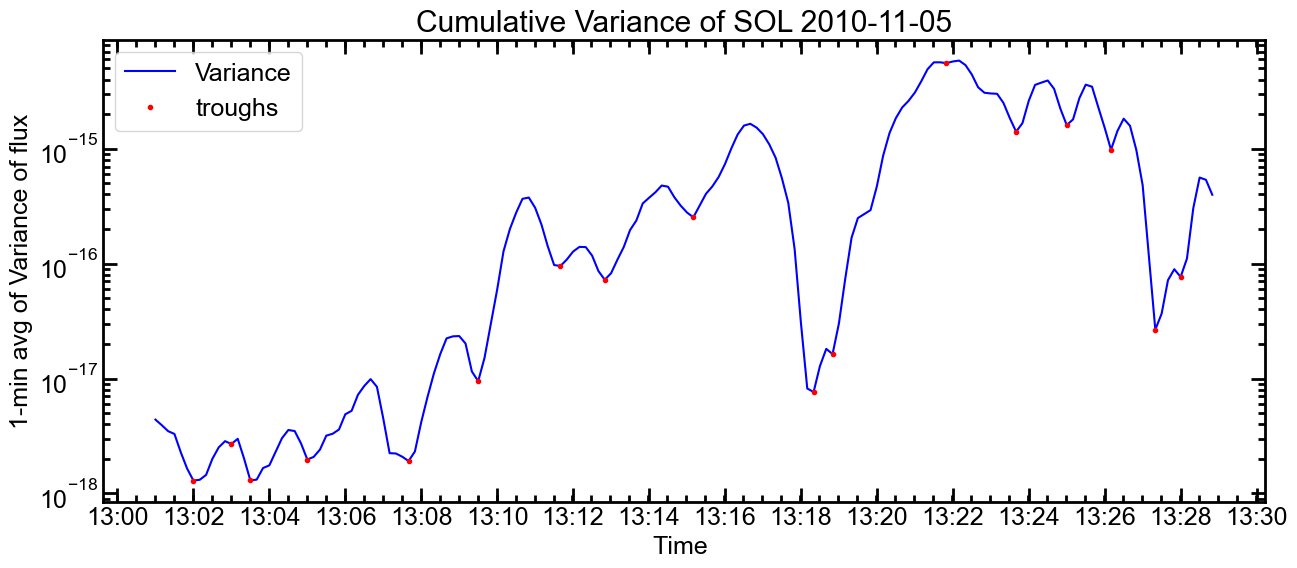

In [55]:
smooth = pd.Series(vars_0, index = pd.DatetimeIndex(g_tims_bcksr))
smooth = smooth.resample('10S').mean()

df = pd.DataFrame({'Time': smooth.index, 'Variance': smooth.values})

#Calculating the turning points through 'find peaks'
troughs, _ = signal.find_peaks(np.negative(df['Variance']))

trough_time = []
trough_var =[]
for t in troughs:
    trough_time.append(df.iloc[t]['Time'])
    trough_var.append(df.iloc[t]['Variance'])


fig,ax = plt.subplots(figsize=(15, 6))
plt.title('Cumulative Variance of SOL 2010-11-05')
# plt.plot(g_tims_srch, np.sqrt(vars), color = 'red', label = 'std')
plt.plot(smooth, color = 'blue', label = 'Variance')
plt.plot(trough_time, trough_var, '.', color = 'red', label = 'troughs')
#plt.plot(troughs, vars[troughs])
# plt.plot(g_tims_srch, g_short_srch, color = 'yellow', label = 'Flux')
# ax.axvline(datetime.strptime("11/05/10 13:29:00", '%m/%d/%y %H:%M:%S'), color = 'black')
# ax.axvline(datetime.strptime("11/05/10 13:08:10", '%m/%d/%y %H:%M:%S'), color = 'r')
# ax.axvline(datetime.strptime("11/05/10 13:09:30", '%m/%d/%y %H:%M:%S'), color = 'r')
ax.set_ylabel("1-min avg of Variance of flux")
ax.set_xlabel("Time ")
ax.set_yscale("log")
#ax.axvline(200)
#ax.set_ylim(10**(-18),10**(-10))
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=30)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
plt.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
plt.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
plt.tick_params(which='major', size=10, width=2, direction='in', right='on')
plt.tick_params(which='minor', size=5, width=2, direction='in', right='on')
plt.legend()
plt.show()

In [56]:
print(trs, troughs)

[  6  12  15  24  40  51  64  71  85 104 107 125 136 144 151 158 162] [ 12  18  21  30  46  57  70  77  91 110 113 131 142 150 157 164 168]


#### Background-subtracted flare 2010-11-05

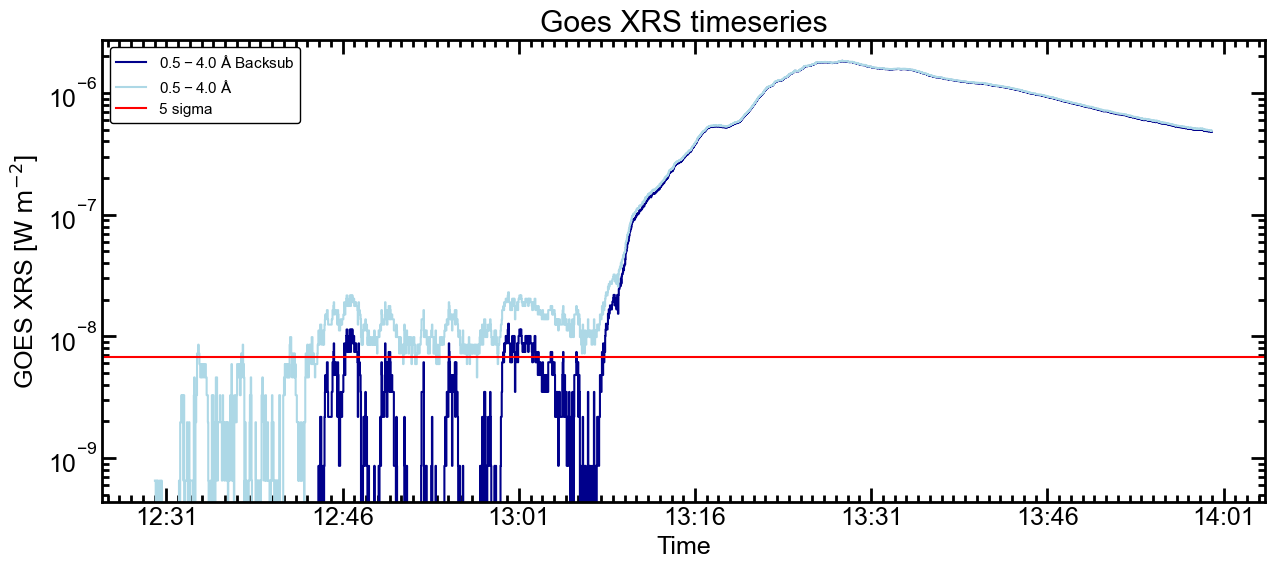

In [57]:
#bcktrange = a.Time("2010-11-05 13:06:19","2010-11-05 13:07:30") #Hugh;s background
bcktrange = a.Time("2010-11-05 13:06:40", "2010-11-05 13:07:40") #My background
bcktrunc_g15=g15.truncate(bcktrange.start.iso,bcktrange.end.iso)
bckg_tims = bcktrunc_g15.index

bckg_short = np.mean(bcktrunc_g15.quantity("xrsa").value)
bckg_short_std = np.std(bcktrunc_g15.quantity("xrsa").value)
bckg_long = np.mean(bcktrunc_g15.quantity("xrsb").value)

g_short_sub = g_short - bckg_short
g_long_sub = g_long - bckg_long

fig,ax = plt.subplots(figsize=(15, 6))
plt.title("Goes XRS timeseries")
plt.plot(g_tims, g_short_sub, drawstyle='steps-post', color = 'darkblue', label = r"$0.5-4.0\;\AA$ Backsub")
plt.plot(g_tims, g_short, drawstyle='steps-post', color = 'lightblue', label = r"$0.5-4.0\;\AA$")
plt.axhline(5*bckg_short_std, label = "5 sigma", color = 'r')
ax.set_ylabel("GOES XRS [$\mathrm{W\;m^{-2}}$] ")
ax.set_xlabel("Time")
ax.set_yscale("log")
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=15)
minorx= matplotlib.dates.MinuteLocator(interval=1)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
plt.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
plt.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
plt.tick_params(which='major', size=10, width=2, direction='in', right='on')
plt.tick_params(which='minor', size=5, width=2, direction='in', right='on')
plt.legend(fancybox = True, fontsize = 11, framealpha = 1, edgecolor = 'black')
plt.show()

#### Start Time of Onset: 5 sigma rule

We will use the '5-sigma' rule to identify the start of the onset phase here. Want to find the first point after the background sub period that is above 5 standard deviations of the variance of the background sub period.

In [58]:
#Start by truncating short channel data from end of background interval - 1 min (or start time) to peak time.
trange_search = a.Time("2010-11-05 13:06:40", "2010-11-05 13:29:00") #Hugh's background time
#trange_search = a.Time("2010-11-05 13:02:08", "2010-11-05 13:29:00") #My background time
trunc_srch = g15.truncate(trange_search.start.iso,trange_search.end.iso)
g_tims_srch = trunc_srch.index
g_short_srch = trunc_srch.quantity("xrsa").value
g_short_srch = g_short_srch - bckg_short

#Find first point above 5-sigma
onset_start = g_tims_srch[(next(i for i, v in enumerate(g_short_srch) if v >= 5*bckg_short_std))]
print(onset_start)


2010-11-05 13:08:04.625000


### End time of onset: Cumulative Variance approach

We will first look at the cumulative variance of the flux, and then the temperature.

In [59]:
#Calculating the cumulative variance at each point
vars = []
for i in range(0,len(g_short_srch)):
    var = np.std(g_short_srch[i-30:i])
    vars.append(var)

smooth = pd.Series(vars, index = pd.DatetimeIndex(g_tims_srch))
smooth = smooth.resample('5S').mean()

df = pd.DataFrame({'Time': smooth.index, 'Variance': smooth.values})

#Calculating the turning points through 'find peaks'
troughs, _ = signal.find_peaks(np.negative(df['Variance']), distance = 10)
trough_time = []
trough_var =[]
for t in troughs:
    trough_time.append(df.iloc[t]['Time'])
    trough_var.append(df.iloc[t]['Variance'])

peaks, _ = signal.find_peaks(df['Variance'], distance = 10)

first_peak_time = df.iloc[peaks[0]]['Time']
for p in range(0, len(peaks)):
    if peaks[p] 
    var_peak_time = df.iloc[peaks[p]]['Time']
    var_peak_var = df.iloc[peaks[p]]['Variance']


fig,ax = plt.subplots(figsize=(15, 6))
plt.title('Cumulative Variance of SOL 2010-11-05')
plt.plot(var_peak_time, var_peak_var, 'x',color = 'black', label = 'First Peak')
plt.plot(smooth, color = 'blue', label = 'Variance')
plt.plot(trough_time, trough_var, '.', color = 'red', label = 'troughs')
#plt.plot(troughs, vars[troughs])
# plt.plot(g_tims_srch, g_short_srch, color = 'yellow', label = 'Flux')
# ax.axvline(datetime.strptime("11/05/10 13:29:00", '%m/%d/%y %H:%M:%S'), color = 'black')
# ax.axvline(datetime.strptime("11/05/10 13:08:10", '%m/%d/%y %H:%M:%S'), color = 'r')
# ax.axvline(datetime.strptime("11/05/10 13:09:30", '%m/%d/%y %H:%M:%S'), color = 'r')
ax.set_ylabel("1-min avg of Variance of flux")
ax.set_xlabel("Time ")
ax.set_yscale("log")
#ax.axvline(200)
#ax.set_ylim(10**(-18),10**(-10))
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=30)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
plt.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
plt.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
plt.tick_params(which='major', size=10, width=2, direction='in', right='on')
plt.tick_params(which='minor', size=5, width=2, direction='in', right='on')
plt.legend()
plt.show()

SyntaxError: expected ':' (330278836.py, line 26)

In [ ]:
print(trough_time)

[Timestamp('2010-11-05 13:09:30'), Timestamp('2010-11-05 13:11:40'), Timestamp('2010-11-05 13:12:55'), Timestamp('2010-11-05 13:15:10'), Timestamp('2010-11-05 13:18:15'), Timestamp('2010-11-05 13:19:45'), Timestamp('2010-11-05 13:21:50'), Timestamp('2010-11-05 13:23:45'), Timestamp('2010-11-05 13:25:05'), Timestamp('2010-11-05 13:26:15'), Timestamp('2010-11-05 13:27:20')]


In [ ]:
print(first_peak_time)

2010-11-05 13:09:05


2010-11-05 13:09:30


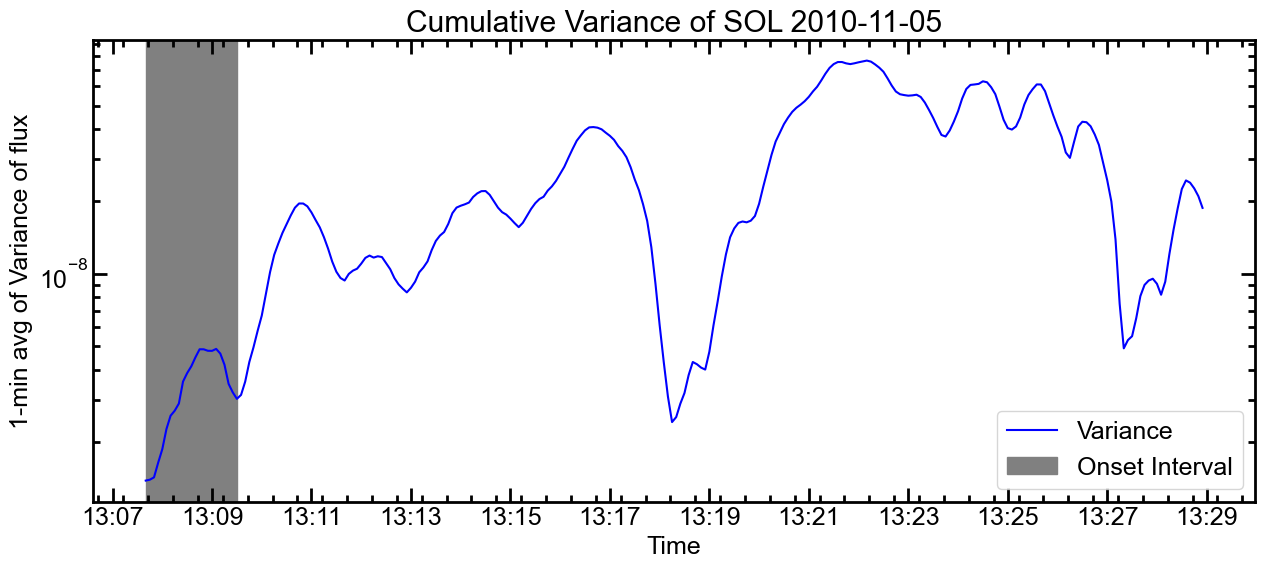

2010-11-05 13:07:40.000
2010-11-05 13:09:30


In [ ]:
for t in range(0, len(trough_time)):
    if trough_time[t] < first_peak_time:
        continue
    else:
        onset_end = trough_time[t]
        if t >=1 :
            onset_start = trough_time[t-1]
        else:
            onset_start = bcktrange.end.iso
        break

print(onset_end)


    # onset_start = trough_time[0]
    # onset_end = trough_time[1]

#print(type(onset_start))

fig,ax = plt.subplots(figsize=(15, 6))
plt.title('Cumulative Variance of SOL 2010-11-05')
plt.plot(smooth, color = 'blue', label = 'Variance')
# ax.axvline(datetime.strptime("11/05/10 13:29:00", '%m/%d/%y %H:%M:%S'), color = 'black')
# ax.axvline(datetime.strptime("11/05/10 13:08:10", '%m/%d/%y %H:%M:%S'), color = 'r')
# ax.axvline(datetime.strptime("11/05/10 13:09:30", '%m/%d/%y %H:%M:%S'), color = 'r')
ax.axvspan(onset_start, onset_end, color = 'grey', label = 'Onset Interval')
ax.set_ylabel("1-min avg of Variance of flux")
ax.set_xlabel("Time")
ax.set_yscale("log")
#ax.axvline(200)
#ax.set_ylim(10**(-18),10**(-10))
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.SecondLocator(interval=30)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
plt.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
plt.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
plt.tick_params(which='major', size=10, width=2, direction='in', right='on')
plt.tick_params(which='minor', size=5, width=2, direction='in', right='on')
plt.legend()
plt.show()

print(onset_start)
print(onset_end)

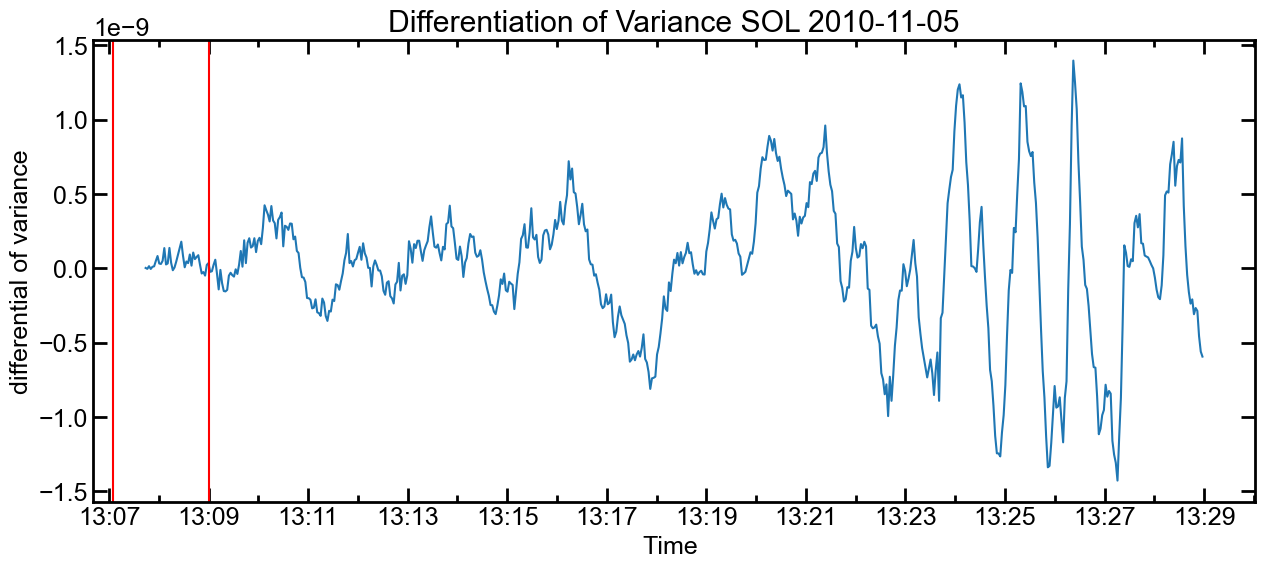

In [ ]:
tmp=pd.Series(vars,g_tims_srch)
tmp.index=pd.to_datetime(tmp.index)

df=pd.DataFrame(tmp)
df['secvalue']=df.index.astype(np.int64)/1e+9
df['slope']= tmp.diff()/df['secvalue'].diff()

fig,ax = plt.subplots(figsize=(15, 6))
plt.title('Differentiation of Variance SOL 2010-11-05')
plt.plot(df.index, df['slope'].values, label = 'slope')
ax.axvline(datetime.strptime("11/05/10 13:07:05", '%m/%d/%y %H:%M:%S'), color = 'r')
ax.axvline(datetime.strptime("11/05/10 13:09:00", '%m/%d/%y %H:%M:%S'), color = 'r')
#plt.plot(df.index, g_short_srch, label = 'Flux')
ax.set_ylabel("differential of variance")
ax.set_xlabel("Time ")
#ax.set_yscale("log")
#ax.set_ylim(-0.001*10**(-10),0.001*10**(-10))
myFmt = matplotlib.dates.DateFormatter('%H:%M')
majorx= matplotlib.dates.MinuteLocator(interval=2)
minorx= matplotlib.dates.MinuteLocator(interval=1)
ax.xaxis.set_major_locator(majorx)
ax.xaxis.set_minor_locator(minorx)
ax.xaxis.set_major_formatter(myFmt)
plt.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
plt.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
plt.tick_params(which='major', size=10, width=2, direction='in', right='on')
plt.tick_params(which='minor', size=5, width=2, direction='in', right='on')
plt.show()

### FFT of flux

C:\Users\William\AppData\Local\Temp\ipykernel_2112\2074864402.py:10: RuntimeWarning: divide by zero encountered in divide
  time_fft = 1/frequencies


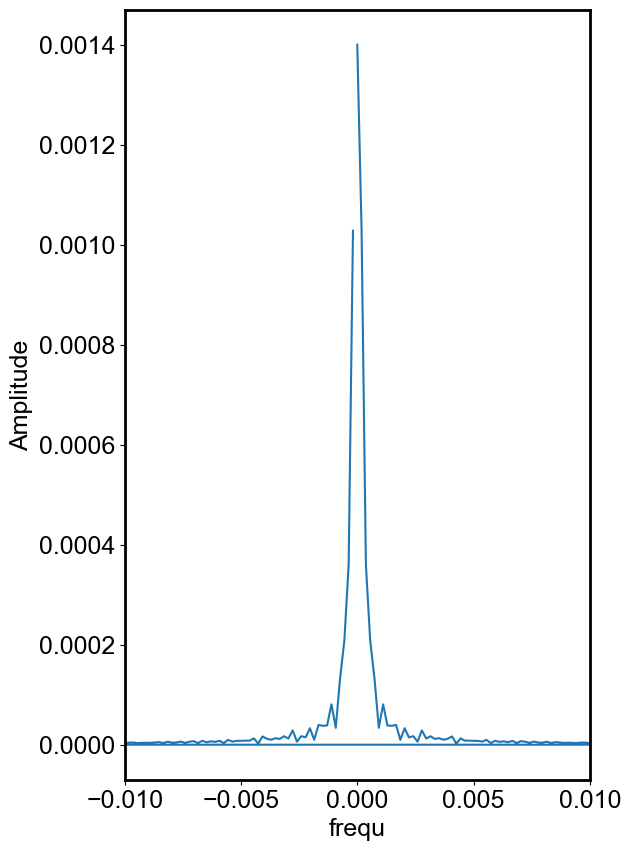

In [ ]:
from scipy.fftpack import fft

dt = (g_tims[1]-g_tims[0]).total_seconds() #calculating time step

# take the Fourier transform
flux_fft = fft(g_short_sub)

# get the frequencies corresponding to the FFT coefficients
frequencies = np.fft.fftfreq(g_tims.shape[-1], d=dt)
time_fft = 1/frequencies
time_fft_datetime = pd.to_datetime(time_fft,unit='s')

# adjust the relative epoch
time_0 = g_tims.max()
time_fft_datetime_adj = time_fft_datetime + (time_0 - time_fft_datetime[1])

# plot the FFT
fig,ax = plt.subplots(figsize=(6, 10))
#ax.plot(time_fft_datetime_adj, np.abs(flux_fft))
ax.plot(frequencies, np.abs(flux_fft))
ax.set_xlabel("frequ")
ax.set_ylabel("Amplitude")
#ax.set_ylim(0,0.00001)
ax.set_xlim(-0.01, 0.01)
# plt.axvline(datetime.strptime("11/05/10 13:07:05", '%m/%d/%y %H:%M:%S'), color = 'r')
# plt.axvline(datetime.strptime("11/05/10 13:09:00", '%m/%d/%y %H:%M:%S'), color = 'r')
# myFmt = matplotlib.dates.DateFormatter('%H:%M')
# majorx= matplotlib.dates.MinuteLocator(interval=30)
# minorx= matplotlib.dates.MinuteLocator(interval=5)
# ax.xaxis.set_major_locator(majorx)
# ax.xaxis.set_minor_locator(minorx)
# ax.xaxis.set_major_formatter(myFmt)
# plt.tick_params('both', which='major', size=10, width=2, direction='in', top='on')
# plt.tick_params('both', which='minor', size=5, width=2, direction='in', top='on')
# plt.tick_params(which='major', size=10, width=2, direction='in', right='on')
# plt.tick_params(which='minor', size=5, width=2, direction='in', right='on')
#plt.legend()
plt.show()


### wavelet transform

In [ ]:
# perform the wavelet transform
wavelet = signal.ricker
scales = np.arange(1, 128)
coeff, freq = signal.cwt(g_short_sub, wavelet, scales)

# identify the hot onset
power_spectrum = np.abs(coefficients) ** 2
hot_onset_index = np.unravel_index(power_spectrum.argmax(), power_spectrum.shape)
hot_onset_time = g_tims[hot_onset_index[1]]
print("Hot onset time:", hot_onset_time)

ValueError: too many values to unpack (expected 2)

#### Cumulative Variance of the Temperature

Onset Start: 2011-08-09 07:47:34
Onset End: 2011-08-09 08:01:30

In [ ]:
trange_onset = a.Time(onset_start, onset_end)
trunc_onset = g15.truncate(trange_onset.start.iso,trange_onset.end.iso)
g_onset_tims = trunc_onset.index
g_onset_short = trunc_onset.quantity("xrsa").value - bckg_short
g_onset_long = trunc_onset.quantity("xrsb").value - bckg_long

# Fetching Temperature and Emission Measures
tmk, em = gtem.get_tem(g_onset_long, g_onset_short)

#calculating mean T, EM for backsubbed new data.
tmk_mnho=np.mean(tmk)
em_mnho=np.mean(em)
print("")
print('Mean T during onset: {0:.2f} MK'.format(tmk_mnho))
print('Mean EM during onset: {0:.2e} cm^-3'.format(em_mnho))


Mean T during onset: 10.41 MK
Mean EM during onset: 6.33e+46 cm^-3


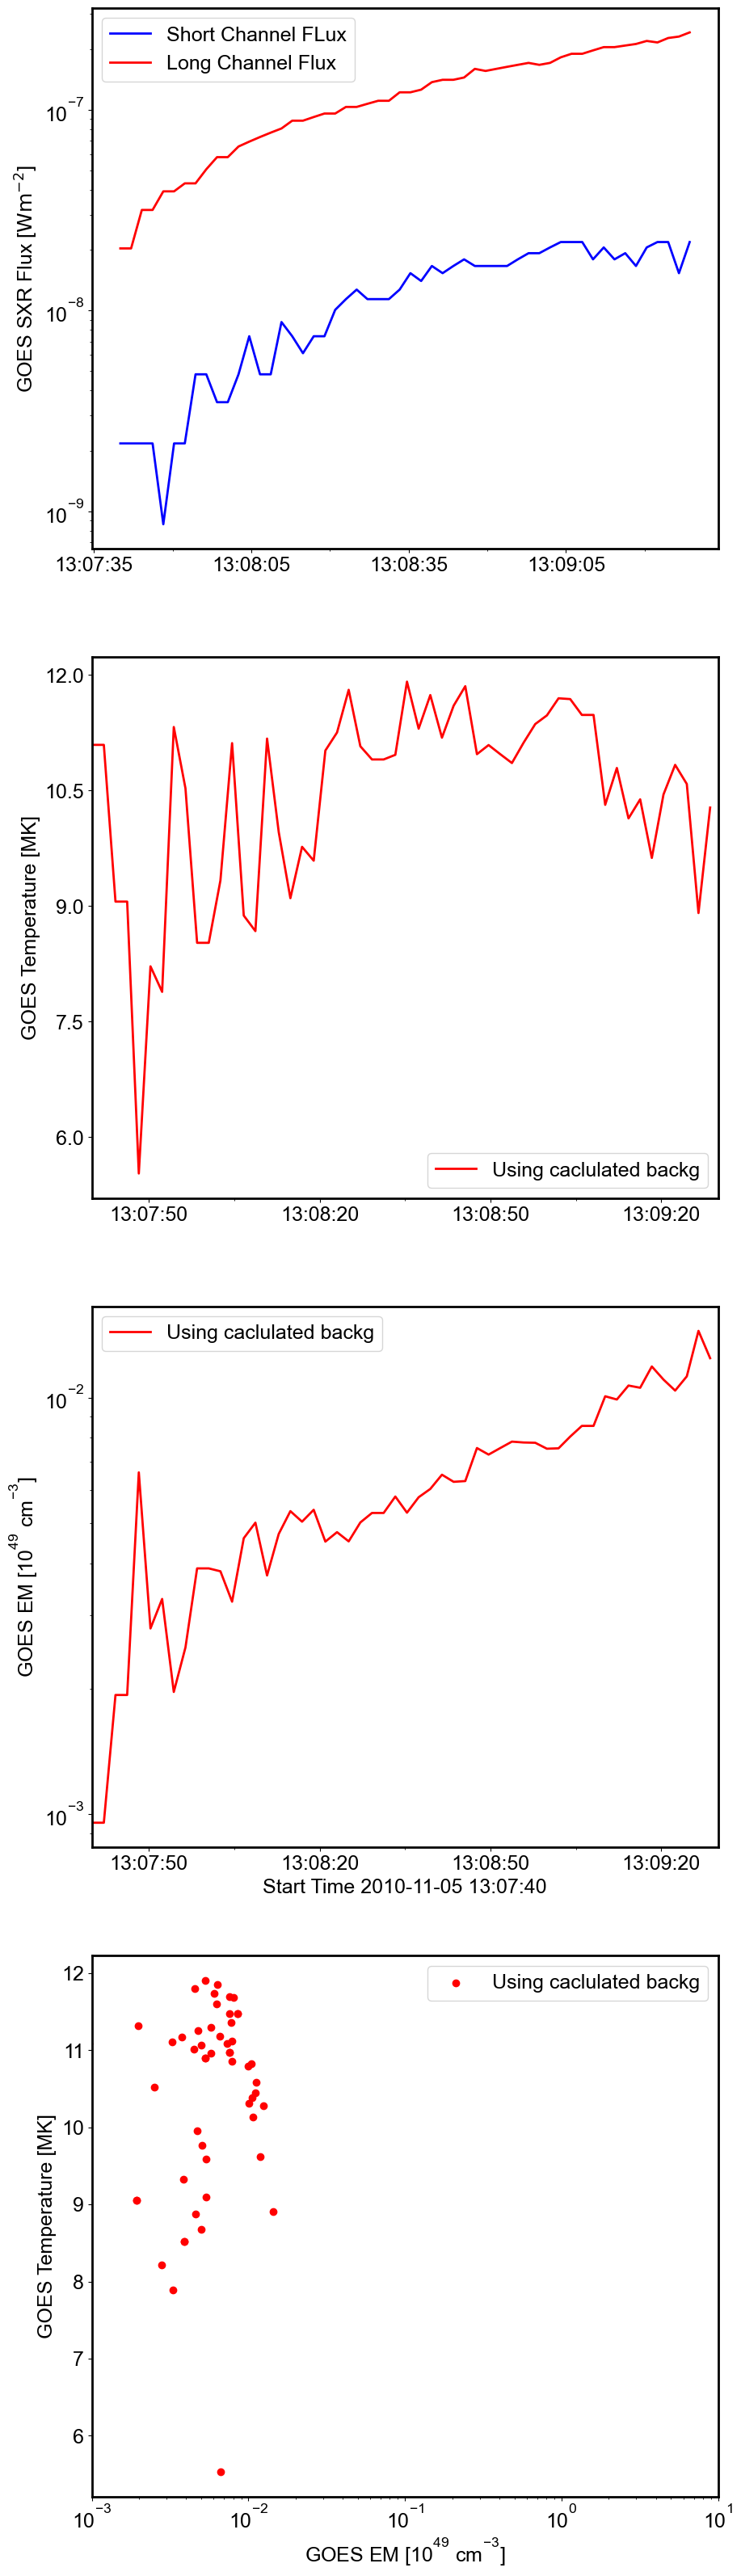

In [ ]:
fig= plt.figure(figsize=(10, 40))

# First plot: non-background subtracted long time-series data
ax0 = fig.add_subplot(4, 1, 1)
plt.plot(g_onset_tims, g_onset_short, marker=None,color='blue',lw=2, label = "Short Channel FLux")
plt.plot(g_onset_tims, g_onset_long, marker=None,color='red',lw=2, label = 'Long Channel Flux')
ax0.set_ylabel("GOES SXR Flux [$\mathrm{Wm^{-2}}$]")
#ax0.set_ylim([10**(-9), 10**(-3)])
#ax0.yaxis.set_major_locator(plt.MaxNLocator(10))
ax0.set_yscale("log")
ax0.set_xlabel(" ")
#ax0.set_xlim([trange.start.datetime,trange.end.datetime])
#ax0.set_xlim([(a.Time('11:30:00', '17:00')).start.datetime,trange.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M:%S')
majorx= matplotlib.dates.SecondLocator(interval=30)
minorx= matplotlib.dates.SecondLocator(interval=15)
ax0.xaxis.set_major_locator(majorx)
ax0.xaxis.set_minor_locator(minorx)
ax0.xaxis.set_major_formatter(myFmt)
#ax0.axvspan(backg_trange.start.datetime,backg_trange.e15nd.datetime,color='grey',alpha=0.4, label='Background')
plt.legend()

# Second plot: background subtracted fluxes to calculate Temperature over short timescale
ax1 = fig.add_subplot(4, 1, 2)
plt.plot(g_onset_tims, tmk,marker=None,color='red',lw=2, label = "Using caclulated backg")
ax1.set_title("")
ax1.set_ylabel("GOES Temperature [MK]")
ax1.set_xlabel(" ")
#ax1.set_ylim([0,20])
ax1.yaxis.set_major_locator(plt.MaxNLocator(5))
ax1.set_xlim([trange_onset.start.datetime,trange_onset.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M:%S')
majorx= matplotlib.dates.SecondLocator(interval=30)
minorx= matplotlib.dates.SecondLocator(interval=15)
ax1.xaxis.set_major_locator(majorx)
ax1.xaxis.set_minor_locator(minorx)
ax1.xaxis.set_major_formatter(myFmt)
plt.legend()

ax2 = fig.add_subplot(4, 1, 3)
plt.plot(g_onset_tims,em*1e-49,marker=None,color='red',lw=2, label = "Using caclulated backg") # Current visualisation using my background
ax2.set_ylabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax2.set_xlabel("Start Time "+trange_onset.start.iso[:-4])
#ax2.set_ylim([1e-3,1e1])
ax2.set_yscale("log")
ax2.set_xlim([trange_onset.start.datetime,trange_onset.end.datetime])
myFmt = matplotlib.dates.DateFormatter('%H:%M:%S')
majorx= matplotlib.dates.SecondLocator(interval=30)
minorx= matplotlib.dates.SecondLocator(interval=15)
ax2.xaxis.set_major_locator(majorx)
ax2.xaxis.set_minor_locator(minorx)
ax2.xaxis.set_major_formatter(myFmt)
plt.legend()

ax3 = fig.add_subplot(4, 1, 4)
plt.scatter(em*1e-49,tmk,marker=None,color='red', label = "Using caclulated backg")
ax3.set_xlabel("GOES EM [$10^{49}\;cm^{-3}$]")
ax3.set_ylabel("GOES Temperature [MK]")
ax3.set_xlim([1e-3,1e1])
#ax3.set_ylim([0,20])
ax3.set_xscale("log")
plt.legend()


plt.show()